In [23]:
from torch.utils.data.dataset import Dataset
import torch
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from abc import ABCMeta, abstractmethod
class AbstractAttacker(metaclass=ABCMeta):
    def __init__(self, splitnn):
        """attacker against SplitNN
        Args:
            splitnn: SplitNN
        """
        self.splitnn = splitnn

    def fit(self):
        pass

    @abstractmethod
    def attack(self):
        pass


class NormAttack(AbstractAttacker):
    def __init__(self, splitnn):
        """Class that implement normattack
        Args:
            splitnn (attack_splitnn.splitnn.SplitNN): target splotnn model
        """
        super().__init__(splitnn)
        self.splitnn = splitnn

    def attack(self, dataloader, criterion, device):
        """Culculate leak_auc on the given SplitNN model
           reference: https://arxiv.org/abs/2102.08504
        Args:
            dataloader (torch dataloader): dataloader for evaluation
            criterion: loss function for training
            device: cpu or GPU
        Returns:
            score: culculated leak auc
        """
        epoch_labels = []
        epoch_g_norm = []
        for i, data in enumerate(dataloader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = self.splitnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            self.splitnn.backward()

            grad_from_server = self.splitnn.client.grad_from_server
            g_norm = grad_from_server.pow(2).sum(dim=1).sqrt()
            epoch_labels.append(labels)
            epoch_g_norm.append(g_norm)

        epoch_labels = torch.cat(epoch_labels)
        epoch_g_norm = torch.cat(epoch_g_norm)
        score = roc_auc_score(epoch_labels, epoch_g_norm.view(-1, 1))
        return score
class DataSet(Dataset):
    """This class allows you to convert numpy.array to torch.Dataset
    Args:
        x (np.array):
        y (np.array):
        transform (torch.transform):
    Attriutes
        x (np.array):
        y (np.array):
        transform (torch.transform):
    """

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)
        return x, y

    def __len__(self):
        """get the number of rows of self.x
        """
        return len(self.x)


def torch_roc_auc_score(label, pred):
    return roc_auc_score(label.cpu().detach().numpy(),
                         pred.cpu().detach().numpy())

/home/yujin/.conda/envs/yjenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
import pandas as pd
raw_df = pd.concat([X, y], axis=1)
raw_df = raw_df.rename(columns={raw_df.columns[-1]: 'label'})
scaler = preprocessing.StandardScaler()
raw_df.iloc[:,:-1] = pd.DataFrame(scaler.fit_transform(raw_df.iloc[:,:-1]), columns = raw_df.iloc[:,:-1].columns)
raw_df_neg = raw_df[raw_df["label"] == 0]
raw_df_pos = raw_df[raw_df["label"] == 1]
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    raw_df.shape[0],raw_df_pos.shape[0], 100 * raw_df_pos.shape[0] / raw_df.shape[0]))


Examples:
    Total: 4601
    Positive: 1813 (39.40% of total)



In [25]:
config = {
    "batch_size":1028
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.3)
# train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df['label'])
bool_train_labels = train_labels != 0
# val_labels = np.array(val_df)
test_labels = np.array(test_df['label'])

train_features = np.array(train_df.drop(['label'],axis=1))
# val_features = np.array(val_df)
test_features = np.array(test_df.drop(['label'],axis=1))
print('Training labels shape:', train_labels.shape)
# print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
# print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)
train_dataset = DataSet(train_features,
                        train_labels.astype(np.float64).reshape(-1, 1))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=config["batch_size"],
                                           shuffle=True)

test_dataset = DataSet(test_features,
                       test_labels.astype(np.float64).reshape(-1, 1))
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=True)

cuda:0
Training labels shape: (3220,)
Test labels shape: (1381,)
Training features shape: (3220, 57)
Test features shape: (1381, 57)


In [26]:
hidden_dim = 10

class FirstNet(nn.Module):
    def __init__(self):
        super(FirstNet, self).__init__()        
        self.L1 = nn.Linear(train_features.shape[-1],
                            hidden_dim)
        self.L2 = nn.Linear(hidden_dim,
                            1)

    def forward(self, x):
        x = self.L1(x)
        x = nn.functional.leaky_relu(x)
        x = self.L2(x)
        x = torch.sigmoid(x)
        # x = nn.functional.leaky_relu(x)
        return x
    
class SecondNet(nn.Module):
    def __init__(self):
        super(SecondNet, self).__init__()        
        self.L1 = nn.Linear(1,
                            hidden_dim)
        self.L2 = nn.Linear(hidden_dim,
                            1)

    def forward(self, x):
        x = self.L1(x)
        x = nn.functional.leaky_relu(x)
        x = self.L2(x)
        # x = nn.functional.leaky_relu(x)
        x = torch.sigmoid(x)
        return x

    
def torch_auc(label, pred):
    return roc_auc_score(label.cpu() .detach().numpy(),
                         pred.cpu() .detach().numpy())

In [27]:
#SplitNN
import torch
class Client(torch.nn.Module):
    def __init__(self, client_model):
        super().__init__()
        """class that expresses the Client on SplitNN
        Args:
            client_model (torch model): client-side model
        Attributes:
            client_model (torch model): cliet-side model
            client_side_intermidiate (torch.Tensor): output of
                                                     client-side model
            grad_from_server
        """

        self.client_model = client_model
        self.client_side_intermidiate = None
        self.grad_from_server = None

    def forward(self, inputs):
        """client-side feed forward network
        Args:
            inputs (torch.Tensor): the input data
        Returns:
            intermidiate_to_server (torch.Tensor): the output of client-side
                                                   model which the client sent
                                                   to the server
        """

        self.client_side_intermidiate = self.client_model(inputs)
        # send intermidiate tensor to the server
        intermidiate_to_server = self.client_side_intermidiate.detach()\
            .requires_grad_()

        return intermidiate_to_server

    def client_backward(self, grad_from_server):
        """client-side back propagation
        Args:
            grad_from_server: gradient which the server send to the client
        """
        self.grad_from_server = grad_from_server
        self.client_side_intermidiate.backward(grad_from_server)

    def train(self):
        self.client_model.train()

    def eval(self):
        self.client_model.eval()


class Server(torch.nn.Module):
    def __init__(self, server_model):
        super().__init__()
        """class that expresses the Server on SplitNN
        Args:
            server_model (torch model): server-side model
        Attributes:
            server_model (torch model): server-side model
            intermidiate_to_server:
            grad_to_client
        """
        self.server_model = server_model

        self.intermidiate_to_server = None
        self.grad_to_client = None

    def forward(self, intermidiate_to_server):
        """server-side training
        Args:
            intermidiate_to_server (torch.Tensor): the output of client-side
                                                   model
        Returns:
            outputs (torch.Tensor): outputs of server-side model
        """
        self.intermidiate_to_server = intermidiate_to_server
        outputs = self.server_model(intermidiate_to_server)

        return outputs

    def server_backward(self):
        self.grad_to_client = self.intermidiate_to_server.grad.clone()
        return self.grad_to_client

    def train(self):
        self.server_model.train()

    def eval(self):
        self.server_model.eval()


class SplitNN(torch.nn.Module):
    def __init__(self, client, server,
                 client_optimizer, server_optimizer
                 ):
        super().__init__()
        """class that expresses the whole architecture of SplitNN
        Args:
            client (attack_splitnn.splitnn.Client):
            server (attack_splitnn.splitnn.Server):
            clietn_optimizer
            server_optimizer
        Attributes:
            client (attack_splitnn.splitnn.Client):
            server (attack_splitnn.splitnn.Server):
            clietn_optimizer
            server_optimizer
        """
        self.client = client
        self.server = server
        self.client_optimizer = client_optimizer
        self.server_optimizer = server_optimizer
        self.grad_to_client =None

        self.intermidiate_to_server = None

    def forward(self, inputs,labels):
        # execute client - feed forward network
        self.labels=labels
        self.intermidiate_to_server = self.client(inputs)
        # execute server - feed forward netwoek
        outputs = self.server(self.intermidiate_to_server)
        # grad_to_client = self.server.server_backward(self.intermidiate_to_server)
        # grad_to_client = self.server.server_backward()

        return outputs,self.intermidiate_to_server

    def backward(self):
        # execute server - back propagation
        self.grad_to_client = self.server.server_backward()
        # execute client - back propagation
        # if model=='Marvell':
        #   grad_to_client=KL_gradient_perturb_function_creator(self.label,grad_to_client)
        
        self.client.client_backward(self.grad_to_client)

    def zero_grads(self):
        self.client_optimizer.zero_grad()
        self.server_optimizer.zero_grad()

    def step(self):
        self.client_optimizer.step()
        self.server_optimizer.step()

    def train(self):
        self.client.train()
        self.server.train()

    def eval(self):
        self.client.eval()
        self.server.eval()

In [28]:
#solve_isotropic_covariance
import math
import random
from collections import Counter
import numpy

OBJECTIVE_EPSILON = 1e-16
CONVEX_EPSILON = 1e-20
NUM_CANDIDATE = 1


def symKL_objective(lam10, lam20, lam11, lam21, u, v, d, g):
    if (lam21 + v) == 0.0 or (lam20 + u) == 0.0 or (lam11 + v) == 0.0 or (lam10 + u) == 0.0:
        return float('inf')
    objective = (d - 1) * (lam20 + u) / (lam21 + v) \
                + (d - 1) * (lam21 + v) / (lam20 + u) \
                + (lam10 + u + g) / (lam11 + v) \
                + (lam11 + v + g) / (lam10 + u)
    return objective


def symKL_objective_zero_uv(lam10, lam11, g):
    objective = (lam10 + g) / lam11 \
                + (lam11 + g) / lam10
    return objective


def solve_isotropic_covariance(u, v, d, g, p, P,
                               lam10_init=None, lam20_init=None,
                               lam11_init=None, lam21_init=None):
    """ return the solution to the optimization problem
        Args:
        u ([type]): [the coordinate variance of the negative examples]
        v ([type]): [the coordinate variance of the positive examples]
        d ([type]): [the dimension of activation to protect]
        g ([type]): [squared 2-norm of g_0 - g_1, i.e. \|g^{(0)} - g^{(1)}\|_2^2]
        P ([type]): [the power constraint value]
    """

    if u == 0.0 and v == 0.0:
        return solve_zero_uv(g=g, p=p, P=P)

    ordering = [0, 1, 2]
    random.shuffle(x=ordering)

    solutions = []
    if u <= v:
        for i in range(NUM_CANDIDATE):
            if i % 3 == ordering[0]:
                # print('a')
                if lam20_init:  # if we pass an initialization
                    lam20 = lam20_init
                    # print('here')
                else:
                    lam20 = random.random() * P / (1 - p) / d
                lam10, lam11 = None, None
                # print('lam21', lam21)
            elif i % 3 == ordering[1]:
                # print('b')
                if lam11_init:
                    lam11 = lam11_init
                else:
                    lam11 = random.random() * P / p
                lam10, lam20 = None, None
                # print('lam11', lam11)
            else:
                # print('c')
                if lam10_init:
                    lam10 = lam10_init
                else:
                    lam10 = random.random() * P / (1 - p)
                lam11, lam20 = None, None
                # print('lam10', lam10)

            solutions.append(solve_small_neg(u=u, v=v, d=d, g=g, p=p, P=P, lam10=lam10, lam11=lam11, lam20=lam20))

    else:
        for i in range(NUM_CANDIDATE):
            if i % 3 == ordering[0]:
                if lam21_init:
                    lam21 = lam21_init
                else:
                    lam21 = random.random() * P / p / d
                lam10, lam11 = None, None
                # print('lam21', lam21)
            elif i % 3 == ordering[1]:
                if lam11_init:
                    lam11 = lam11_init
                else:
                    lam11 = random.random() * P / p
                lam10, lam21 = None, None
                # print('lam11', lam11)
            else:
                if lam10_init:
                    lam10 = lam10_init
                else:
                    lam10 = random.random() * P / (1 - p)
                lam11, lam21 = None, None
                # print('lam10', lam10)

            solutions.append(solve_small_pos(u=u, v=v, d=d, g=g, p=p, P=P, lam10=lam10, lam11=lam11, lam21=lam21))

    # print(solutions)
    lam10, lam20, lam11, lam21, objective = min(solutions, key=lambda x: x[-1])

    # print('sum', p * lam11 + p*(d-1)*lam21 + (1-p) * lam10 + (1-p)*(d-1)*lam20)

    return (lam10, lam20, lam11, lam21, objective)


def solve_zero_uv(g, p, P):
    C = P

    E = math.sqrt((C + (1 - p) * g) / (C + p * g))
    tau = max((P / (p)) / (E + (1 - p) /  (p)), 0.0)
    # print('tau', tau)
    if 0 <= tau and tau <= P / (1 - p):
        # print('A')
        lam10 = tau
        lam11 = max(P /  (p) - (1 - p) * tau /  (p), 0.0)
    else:
        # print('B')
        lam10_case1, lam11_case1 = 0.0, max(P /  (p), 0.0)
        lam10_case2, lam11_case2 = max(P / (1 - p), 0), 0.0
        objective1 = symKL_objective_zero_uv(lam10=lam10_case1, lam11=lam11_case1,
                                             g=g)
        objective2 = symKL_objective_zero_uv(lam10=lam10_case2, lam11=lam11_case2,
                                             g=g)
        if objective1 < objective2:
            lam10, lam11 = lam10_case1, lam11_case1
        else:
            lam10, lam11 = lam10_case2, lam11_case2

    objective = symKL_objective_zero_uv(lam10=lam10, lam11=lam11, g=g)
    # here we subtract d = 1 because the distribution is essentially one-dimensional
    return (lam10, 0.0, lam11, 0.0, 0.5 * objective - 1)


def solve_small_neg(u, v, d, g, p, P, lam10=None, lam20=None, lam11=None):
    """[When u < v]
    """
    # some intialization to start the alternating optimization
    LAM21 = 0.0
    i = 0
    objective_value_list = []

    if lam20:
        ordering = [0, 1, 2]
    elif lam11:
        ordering = [1, 0, 2]
    else:
        ordering = [1, 2, 0]
    # print(ordering)

    while True:
        if i % 3 == ordering[0]:  # fix lam20
            D = P - (1 - p) * (d - 1) * lam20
            C = D + p * v + (1 - p) * u

            E = math.sqrt((C + (1 - p) * g) / (C + p * g))
            tau = max((D / p + v - E * u) / (E + (1 - p) / p), 0.0)
            # print('tau', tau)
            if lam20 <= tau and tau <= P / (1 - p) - (d - 1) * lam20:
                # print('A')
                lam10 = tau
                lam11 = max(D / p - (1 - p) * tau / p, 0.0)
            else:
                # print('B')
                lam10_case1, lam11_case1 = lam20, max(P / p - (1 - p) * d * lam20 / p, 0.0)
                lam10_case2, lam11_case2 = max(P / (1 - p) - (d - 1) * lam20, 0), 0.0
                objective1 = symKL_objective(lam10=lam10_case1, lam20=lam20, lam11=lam11_case1, lam21=LAM21,
                                             u=u, v=v, d=d, g=g)
                objective2 = symKL_objective(lam10=lam10_case2, lam20=lam20, lam11=lam11_case2, lam21=LAM21,
                                             u=u, v=v, d=d, g=g)
                if objective1 < objective2:
                    lam10, lam11 = lam10_case1, lam11_case1
                else:
                    lam10, lam11 = lam10_case2, lam11_case2

        elif i % 3 == ordering[1]:  # fix lam11
            D = max((P - p * lam11) / (1 - p), 0.0)
            f = lambda x: symKL_objective(lam10=D - (d - 1) * x, lam20=x, lam11=lam11, lam21=LAM21,
                                          u=u, v=v, d=d, g=g)

            # f_prime = lambda x: (d-1)/v - (d-1)/(lam11+v) - (d-1)*v/((x+u)**2) + (lam11 + v + g)*(d-1)/((D-(d-1)*x+u)**2) # not numerically stable
            # f_prime = lambda x: (d-1)/v - (d-1)/(lam11+v) - (d-1)/(x+u)*(v/(x+u)) + (lam11 + v + g)/(D-(d-1)*x+u) * ((d-1)/(D-(d-1)*x+u))

            def f_prime(x):
                if x == 0.0 and u == 0.0:
                    return float('-inf')
                else:
                    return (d - 1) / v - (d - 1) / (lam11 + v) - (d - 1) / (x + u) * (v / (x + u)) + (lam11 + v + g) / (
                                D - (d - 1) * x + u) * ((d - 1) / (D - (d - 1) * x + u))

            # print('D/d', D/d)
            lam20 = convex_min_1d(xl=0.0, xr=D / d, f=f, f_prime=f_prime)
            lam10 = max(D - (d - 1) * lam20, 0.0)

        else:  # fix lam10
            D = max(P - (1 - p) * lam10, 0.0)  # avoid negative due to numerical error
            f = lambda x: symKL_objective(lam10=lam10, lam20=x, lam11=D / p - (1 - p) * (d - 1) * x / p, lam21=LAM21,
                                          u=u, v=v, d=d, g=g)

            # f_prime = lambda x: (d-1)/v - (1-p)*(d-1)/(lam10 + u)/p - (d-1)*v/((x+u)**2) + (lam10+u+g)*(1-p)*(d-1)/p/((D/p - (1-p)*(d-1)*x/p + v)**2) # not numerically stable
            # f_prime = lambda x: (d-1)/v - (1-p)*(d-1)/(lam10 + u)/p - (d-1)/(x+u)*(v/(x+u)) + (lam10+u+g)/(D/p - (1-p)*(d-1)*x/p + v) * (1-p) * (d-1) / p / (D/p - (1-p)*(d-1)*x/p + v)

            def f_prime(x):
                if x == 0.0 and u == 0.0:
                    return float('-inf')
                else:
                    return (d - 1) / v - (1 - p) * (d - 1) / (lam10 + u) / p - (d - 1) / (x + u) * (v / (x + u)) + (
                                lam10 + u + g) / (D / p - (1 - p) * (d - 1) * x / p + v) * (1 - p) * (d - 1) / p / (
                                       D / p - (1 - p) * (d - 1) * x / p + v)

            # print('lam10', 'D/((1-p)*(d-1)', lam10, D/((1-p)*(d-1)))
            lam20 = convex_min_1d(xl=0.0, xr=min(D / ((1 - p) * (d - 1)), lam10), f=f, f_prime=f_prime)
            lam11 = max(D / p - (1 - p) * (d - 1) * lam20 / p, 0.0)

        if lam10 < 0 or lam20 < 0 or lam11 < 0 or LAM21 < 0:  # check to make sure no negative values
            assert False, i

        objective_value_list.append(symKL_objective(lam10=lam10, lam20=lam20, lam11=lam11, lam21=LAM21,
                                                    u=u, v=v, d=d, g=g))
        # print(i)
        # print(objective_value_list[-1])
        # print(lam10, lam20, lam11, LAM21, objective_value_list[-1])
        # print('sum', p * lam11 + p*(d-1)*LAM21 + (1-p) * lam10 + (1-p)*(d-1)*lam20)

        if (i >= 3 and objective_value_list[-4] - objective_value_list[-1] < OBJECTIVE_EPSILON) or i >= 100:
            # print(i)
            return lam10, lam20, lam11, LAM21, 0.5 * objective_value_list[-1] - d

        i += 1


def solve_small_pos(u, v, d, g, p, P, lam10=None, lam11=None, lam21=None):
    """[When u > v] lam20 = 0.0 and will not change throughout the optimization
    """
    # some intialization to start the alternating optimization
    LAM20 = 0.0
    i = 0
    objective_value_list = []
    if lam21:
        ordering = [0, 1, 2]
    elif lam11:
        ordering = [1, 0, 2]
    else:
        ordering = [1, 2, 0]
    # print(ordering)
    while True:
        if i % 3 == ordering[0]:  # fix lam21
            D = P - p * (d - 1) * lam21
            C = D + p * v + (1 - p) * u

            E = math.sqrt((C + (1 - p) * g) / (C + p * g))
            tau = max((D / p + v - E * u) / (E + (1 - p) / p), 0.0)
            # print('tau', tau)
            if 0.0 <= tau and tau <= (P - p * d * lam21) / (1 - p):
                # print('A')
                lam10 = tau
                lam11 = max(D / (p) - (1 - p) * tau / (p), 0.0)
            else:
                # print('B')
                lam10_case1, lam11_case1 = 0, max(P / p - (d - 1) * lam21, 0.0)
                lam10_case2, lam11_case2 = max((P - p * d * lam21) / (1 - p), 0.0), lam21
                objective1 = symKL_objective(lam10=lam10_case1, lam20=LAM20, lam11=lam11_case1, lam21=lam21,
                                             u=u, v=v, d=d, g=g)
                objective2 = symKL_objective(lam10=lam10_case2, lam20=LAM20, lam11=lam11_case2, lam21=lam21,
                                             u=u, v=v, d=d, g=g)
                if objective1 < objective2:
                    lam10, lam11 = lam10_case1, lam11_case1
                else:
                    lam10, lam11 = lam10_case2, lam11_case2

        elif i % 3 == ordering[1]:  # fix lam11
            D = max(P - p * lam11, 0.0)
            f = lambda x: symKL_objective(lam10=(D - p * (d - 1) * x) / (1 - p), lam20=LAM20, lam11=lam11, lam21=x,
                                          u=u, v=v, d=d, g=g)

            # f_prime = lambda x: (d-1)/u - p*(d-1)/(lam11+v)/(1-p) - (d-1)*u/((x+v)**2) + (lam11 + v + g)*p*(d-1)/(1-p)/(((D - p*(d-1)*x)/(1-p) + u)**2) # not numerically stable
            # print('D', D)
            # print('P', P)
            # print('d', d)
            # print('u', u)
            # print('v', v)
            # print('g', g)
            # print('p', p)
            # print('lam11', lam11)
            # print()

            # f_prime = lambda x: (d-1)/u - p*(d-1)/(lam11+v)/(1-p) - (d-1)/(x+v)*(u/(x+v)) + (lam11 + v + g) / ((D - p*(d-1)*x)/(1-p) + u) * p * (d-1) / (1-p) /((D - p*(d-1)*x)/(1-p) + u)

            def f_prime(x):
                if x == 0.0 and v == 0.0:
                    return float('-inf')
                else:
                    return (d - 1) / u - p * (d - 1) / (lam11 + v) / (1 - p) - (d - 1) / (x + v) * (u / (x + v)) + (
                                lam11 + v + g) / ((D - p * (d - 1) * x) / (1 - p) + u) * p * (d - 1) / (1 - p) / (
                                       (D - p * (d - 1) * x) / (1 - p) + u)

            # print('lam11', 'D/p/(d-1)', lam11, D/p/(d-1))
            lam21 = convex_min_1d(xl=0.0, xr=min(D / p / (d - 1), lam11), f=f, f_prime=f_prime)
            lam10 = max((D - p * (d - 1) * lam21) / (1 - p), 0.0)

        else:  # fix lam10
            D = max((P - (1 - p) * lam10) / p, 0.0)
            f = lambda x: symKL_objective(lam10=lam10, lam20=LAM20, lam11=D - (d - 1) * x, lam21=x,
                                          u=u, v=v, d=d, g=g)

            # f_prime = lambda x: (d-1)/u - (d-1)/(lam10+u) - (d-1)*u/((x+v)**2) + (lam10 + u + g)*(d-1)/((D-(d-1)*x+v)**2)

            # print('D', D)
            # print('P', P)
            # print('d', d)
            # print('u', u)
            # print('v', v)
            # print('g', g)
            # print('p', p)
            # print('lam10', lam10)
            # print()

            # f_prime = lambda x: (d-1)/u - (d-1)/(lam10+u) - (d-1)/(x+v)*(u/(x+v)) + (lam10 + u + g)/(D-(d-1)*x+v) * (d-1) / (D-(d-1)*x+v)

            def f_prime(x):
                if x == 0.0 and v == 0.0:
                    return float('-inf')
                else:
                    return (d - 1) / u - (d - 1) / (lam10 + u) - (d - 1) / (x + v) * (u / (x + v)) + (lam10 + u + g) / (
                                D - (d - 1) * x + v) * (d - 1) / (D - (d - 1) * x + v)

            # def f_prime(x):
            #     print('x', x)
            #     print('d, u, v, g', d, u, v, g)
            #     print('(d-1)/u', (d-1)/u)
            #     print('(d-1)/(lam10+u)', (d-1)/(lam10+u))
            #     print('(d-1)*u/((x+v)**2)', (d-1)*u/((x+v)**2))
            #     print('(lam10 + u + g)*(d-1)/((D-(d-1)*x+v)**2)', (lam10 + u + g)*(d-1)/((D-(d-1)*x+v)**2))

            #     return (d-1)/u - (d-1)/(lam10+u) - (d-1)*u/((x+v)**2) + (lam10 + u + g)*(d-1)/((D-(d-1)*x+v)**2)
            # print('D/d', D/d)
            lam21 = convex_min_1d(xl=0.0, xr=D / d, f=f, f_prime=f_prime)
            lam11 = max(D - (d - 1) * lam21, 0.0)

        if lam10 < 0 or LAM20 < 0 or lam11 < 0 or lam21 < 0:
            assert False, i

        objective_value_list.append(symKL_objective(lam10=lam10, lam20=LAM20, lam11=lam11, lam21=lam21,
                                                    u=u, v=v, d=d, g=g))
        # print(i)
        # print(objective_value_list[-1])
        # print(lam10, LAM20, lam11, lam21)
        # print('sum', p * lam11 + p*(d-1)*lam21 + (1-p) * lam10 + (1-p)*(d-1)*LAM20)

        if (i >= 3 and objective_value_list[-4] - objective_value_list[-1] < OBJECTIVE_EPSILON) or i >= 100:
            # print(i)
            return lam10, LAM20, lam11, lam21, 0.5 * objective_value_list[-1] - d

        i += 1


def convex_min_1d(xl, xr, f, f_prime):
    # print('xl, xr', xl, xr)
    assert xr <= 1e5
    assert xl <= xr, (xl, xr)
    # print('xl, xr', xl, xr)

    xm = (xl + xr) / 2
    # print('xl', xl, f(xl), f_prime(xl))
    # print('xr', xr, f(xr), f_prime(xr))
    # print('xm', xm, f(xm), f_prime(xm))
    # print('abs(xl - xr) <= CONVEX_EPSILON',abs(xl - xr) <= CONVEX_EPSILON,abs(xl - xr) , CONVEX_EPSILON)
    if abs(xl - xr) <= CONVEX_EPSILON:
        # print('min((f(x), x) for x in [xl, xm, xr])[1]',min((f(x), x) for x in [xl, xm, xr])[1])
        return min((f(x), x) for x in [xl, xm, xr])[1]
    if f_prime(xl) <= 0 and f_prime(xr) <= 0:
        return xr
    elif f_prime(xl) >= 0 and f_prime(xr) >= 0:
        return xl
    if f_prime(xm) > 0:
        # print('xm', xm, f(xm), f_prime(xm))
        return convex_min_1d(xl=xl, xr=xm, f=f, f_prime=f_prime)
    else:
        # print('xm', xm, f(xm), f_prime(xm))
        return convex_min_1d(xl=xm, xr=xr, f=f, f_prime=f_prime)


def small_neg_problem_string(u, v, d, g, p, P):
    return 'minimize ({2}-1)*(z + {0})/{1} + ({2}-1)*{1}/(z+{0})+(x+{0}+{3})/(y+{1}) + (y+{1}+{3})/(x+{0}) subject to x>=0, y>=0, z>=0, z<=x, {4}*y+(1-{4})*x+(1-{4})*({2}-1)*z={5}'.format(
        u, v, d, g, p, P)


def small_pos_problem_string(u, v, d, g, p, P):
    return 'minimize ({2}-1)*{0}/(z+{1}) + ({2}-1)*(z + {1})/{0} + (x+{0}+{3})/(y+{1}) + (y+{1}+{3})/(x+{0}) subject to x>=0, y>=0, z>=0, z<=y, {4}*y+(1-{4})*x+{4}*({2}-1)*z={5}'.format(
        u, v, d, g, p, P)


def zero_uv_problem_string(g, p, P):
    return 'minimize (x+{0})/y + (y+{0})/x subject to x>=0, y>=0, {1}*y+(1-{1})*x={2}'.format(g, p, P)

def KL_gradient_perturb_function_creator(Y_Train,g,p_frac='pos_frac', dynamic=False, error_prob_lower_bound=None,
                                         sumKL_threshold=None, init_scale=1.0, uv_choice='uv'):
    # print('p_frac', p_frac)
    # print('dynamic', dynamic)
    if dynamic and (error_prob_lower_bound is not None):
        '''
        if using dynamic and error_prob_lower_bound is specified, we use it to 
        determine the sumKL_threshold and overwrite what is stored in it before.
        '''
        sumKL_threshold = (2 - 4 * error_prob_lower_bound) ** 2
        # print('error_prob_lower_bound', error_prob_lower_bound)
        # print('implied sumKL_threshold', sumKL_threshold)
    # elif dynamic:
    #     print('using sumKL_threshold', sumKL_threshold)

    # print('init_scale', init_scale)
    # print('uv_choice', uv_choice)

    y = list(Y_Train.iloc[:,0])
    pos, neg = [], []
    for i in range(len(y)):
        if y[i] == 1:
            pos.append(i)
        else:
            neg.append(i)
    # print('pos', pos)
    pos_g = [g[i] for i in pos]

    pos_g_mean =numpy.mean(pos_g)
    pos_coordinate_var=numpy.var(pos_g)
    neg_g =[g[i] for i in neg]
    neg_g_mean =numpy.mean(neg_g)
    neg_coordinate_var =numpy.var(neg_g)

    avg_pos_coordinate_var = numpy.mean(pos_coordinate_var)
    avg_neg_coordinate_var = numpy.mean(neg_coordinate_var)

    g_diff = pos_g_mean - neg_g_mean
    g_diff_norm = numpy.sqrt(g_diff**2)


    if uv_choice == 'uv':
        u = float(avg_neg_coordinate_var)
        v = float(avg_pos_coordinate_var)
        # if u == 0.0:
        #     print('neg_g')
        #     print(neg_g)
        # if v == 0.0:
        #     print('pos_g')
        #     print(pos_g)

    if uv_choice == 'same':
          u = float(avg_neg_coordinate_var + avg_pos_coordinate_var) / 2.0
          v = float(avg_neg_coordinate_var + avg_pos_coordinate_var) / 2.0
    elif uv_choice == 'zero':
          u, v = 0.0, 0.0

    d = len(Y_Train)
    if p_frac == 'pos_frac':
          p = float(numpy.sum(y) / len(y))  # p is set as the fraction of positive in the batch
    else:
          p = float(p_frac)

    scale = init_scale
    lam10, lam20, lam11, lam21 = None, None, None, None
    while True:
       P = scale * g_diff_norm ** 2
            # print('g_diff_norm ** 2', g_diff_norm ** 2)
            # print('P', P)
            # print('u, v, d, p', u, v, d, p)
       lam10, lam20, lam11, lam21, sumKL = \
                    solve_isotropic_covariance(
                        u=u,
                        v=v,
                        d=d,
                        g=g_diff_norm ** 2,
                        p=p,
                        P=P,
                        lam10_init=lam10,
                        lam20_init=lam20,
                        lam11_init=lam11,
                        lam21_init=lam21)
       if not dynamic or sumKL <= sumKL_threshold:break



    perturbed_g = g
    perturbed_g += numpy.multiply(numpy.random.normal(0,1,len(y)),
                                                      y) * g_diff * (
                                           numpy.sqrt(lam11 - lam21) / g_diff_norm)
    # print(',g,perturbed_g,lam11 , lam21,g_diff',g,perturbed_g,lam11 , lam21,g_diff)

    if lam21 > 0.0:
      perturbed_g += numpy.random.normal(0,1,len(y)) * y * numpy.sqrt(
                        lam21)
      # print('0 perturbed_g lam21',lam21,perturbed_g)

                    # negative examples add noise in g1 - g0
    perturbed_g += numpy.multiply(numpy.random.normal(0,1,len(y)),
                                                      [1-y[i] for i in range(len(y))]) * g_diff * (
                                           numpy.sqrt(lam10 - lam20) / g_diff_norm)
    #print('1 lam21,g_diff_norm,perturbed_g ,',lam21,g_diff_norm,perturbed_g)


                # add spherical noise to negative examples
    if lam20 > 0.0:
          perturbed_g +=numpy.random.normal(0,1,len(y)) *[1-y[i] for i in range(len(y))] * numpy.sqrt(
                        lam20)
          # print('2 perturbed_g',perturbed_g)
    return perturbed_g

In [29]:
#SplitNN
import torch
class Client_marvell(torch.nn.Module):
    def __init__(self, client_model):
        super().__init__()
        """class that expresses the Client on SplitNN
        Args:
            client_model (torch model): client-side model
        Attributes:
            client_model (torch model): cliet-side model
            client_side_intermidiate (torch.Tensor): output of
                                                     client-side model
            grad_from_server
        """

        self.client_model = client_model
        self.client_side_intermidiate = None
        self.grad_from_server = None

    def forward(self, inputs):
        """client-side feed forward network
        Args:
            inputs (torch.Tensor): the input data
        Returns:
            intermidiate_to_server (torch.Tensor): the output of client-side
                                                   model which the client sent
                                                   to the server
        """

        self.client_side_intermidiate = self.client_model(inputs)
        # send intermidiate tensor to the server
        intermidiate_to_server = self.client_side_intermidiate.detach()\
            .requires_grad_()

        return intermidiate_to_server

    def client_backward(self, grad_from_server):
        """client-side back propagation
        Args:
            grad_from_server: gradient which the server send to the client
        """
        self.grad_from_server = grad_from_server
        self.client_side_intermidiate.backward(grad_from_server)

    def train(self):
        self.client_model.train()

    def eval(self):
        self.client_model.eval()


class Server_marvell(torch.nn.Module):
    def __init__(self, server_model):
        super().__init__()
        """class that expresses the Server on SplitNN
        Args:
            server_model (torch model): server-side model
        Attributes:
            server_model (torch model): server-side model
            intermidiate_to_server:
            grad_to_client
        """
        self.server_model = server_model

        self.intermidiate_to_server = None
        self.grad_to_client = None

    def forward(self, intermidiate_to_server):
        """server-side training
        Args:
            intermidiate_to_server (torch.Tensor): the output of client-side
                                                   model
        Returns:
            outputs (torch.Tensor): outputs of server-side model
        """
        self.intermidiate_to_server = intermidiate_to_server
        # print('intermidiate_to_server',intermidiate_to_server)
        outputs = self.server_model(intermidiate_to_server)

        return outputs

    def server_backward(self):
        self.grad_to_client = self.intermidiate_to_server.grad.clone()
        return self.grad_to_client

    def train(self):
        self.server_model.train()

    def eval(self):
        self.server_model.eval()


class SplitNN_marvell(torch.nn.Module):
    def __init__(self, client, server,
                 client_optimizer, server_optimizer,init_scale
                 ):
        super().__init__()
        """class that expresses the whole architecture of SplitNN
        Args:
            client (attack_splitnn.splitnn.Client):
            server (attack_splitnn.splitnn.Server):
            clietn_optimizer
            server_optimizer
        Attributes:
            client (attack_splitnn.splitnn.Client):
            server (attack_splitnn.splitnn.Server):
            clietn_optimizer
            server_optimizer
        """
        self.client = client
        self.server = server
        self.client_optimizer = client_optimizer
        self.server_optimizer = server_optimizer
        self.grad_to_client=None
        self.grad_to_client_1=None
        self.init_scale = init_scale

        self.intermidiate_to_server = None

    def forward(self, inputs,labels):
        # execute client - feed forward network
        self.intermidiate_to_server = self.client(inputs)
        # execute server - feed forward netwoek
        # g_o=self.intermidiate_to_server1.grad.clone()
        outputs = self.server(self.intermidiate_to_server)
        self.labels=pd.DataFrame(labels.cpu().detach().numpy())
    

        return outputs,self.intermidiate_to_server

    def backward(self):
        # execute server - back propagation
        self.grad_to_client_1 = self.server.server_backward()
        # print(' self.grad_to_client_1',self.grad_to_client_1)

       
        self.grad_to_client=KL_gradient_perturb_function_creator(self.labels,
                                                            self.grad_to_client_1.cpu().detach().numpy().T[0],
                                              dynamic=False, error_prob_lower_bound=None,
                                         sumKL_threshold=None, init_scale=self.init_scale, uv_choice='uv')
        # print(' self.grad_to_client',self.grad_to_client)
        # print('grad_to_client',grad_to_client)
        self.grad_to_client=torch.Tensor(self.grad_to_client).reshape(-1,1)
        self.grad_to_client = self.grad_to_client.to(device)
        # execute client - back propagation
        # if model=='Marvell':
        # print('grad_to_client before',grad_to_client.T)
        # print('grad_to_client.detach().numpy().T[0]',grad_to_client.detach().numpy().T[0])
      
        # print('grad_to_client after',grad_to_client.T)
        
        self.client.client_backward(self.grad_to_client)

    def zero_grads(self):
        self.client_optimizer.zero_grad()
        self.server_optimizer.zero_grad()

    def step(self):
        self.client_optimizer.step()
        self.server_optimizer.step()

    def train(self):
        self.client.train()
        self.server.train()

    def eval(self):
        self.client.eval()
        self.server.eval()

In [46]:
def train_marvell(Epochs,lr = 1e-4,init_scale=1,info=True):
  model_1 = FirstNet()
  model_1 = model_1.to(device)

  model_2 = SecondNet()
  model_2 = model_2.to(device)

  model_1.double()
  model_2.double()

  opt_1 = optim.Adam(model_1.parameters(), lr=lr)
  opt_2 = optim.Adam(model_2.parameters(), lr=lr)

  BCE = nn.BCELoss()

  client = Client_marvell(model_1)
  server = Server_marvell(model_2)

  splitnn_marvell = SplitNN_marvell(client, server, opt_1, opt_2,init_scale)
  splitnn_marvell.train()

  for epoch in range(Epochs):
    epoch_loss = 0
    epoch_outputs = []
    epoch_labels = []
    epoch_outputs_test = []
    epoch_labels_test = []
    epoch_g_norm=[]
    epoch_g_mean=[]
    epoch_g_inner=[]
    epoch_g=[]
    for i, data in enumerate(train_loader):
        splitnn_marvell.zero_grads()
        inputs, labels = data
        inputs = inputs.to(device).double()
        labels = labels.to(device).double()
        
        outputs,intermidiate_to_server = splitnn_marvell(inputs,labels)
        loss = BCE(outputs, labels)
        loss.backward()
        splitnn_marvell.backward()
        splitnn_marvell.step()

        epoch_loss += loss.item() / len(train_loader.dataset)
        
        epoch_outputs.append(outputs)
        epoch_labels.append(labels)

        grad_from_server =splitnn_marvell.client.grad_from_server
        g=list(grad_from_server.cpu().detach().numpy())
        g_norm = grad_from_server.pow(2).sum(dim=1).sqrt()
        v_1=np.multiply(grad_from_server.cpu().detach().numpy(),labels.cpu().detach().numpy())
        mean_1=v_1.sum()/len(v_1[v_1!=0])
        mean_0=(grad_from_server.cpu().detach().numpy().sum()-
               v_1.sum())/len(v_1[v_1==0])

        
        g_mean=[]
        for a in g:
          if (a-mean_1)**2<(a-mean_0)**2:g_mean.append([1])
          else:g_mean.append([0])
        g_mean=torch.tensor(g_mean)
        g_inner=[]
        g=list(grad_from_server.cpu().detach().numpy())
        g_inner=[]
        for a in g:
          if a>grad_from_server.median().item():g_inner.append(1)
          else:g_inner.append(0)
        g_inner=torch.tensor(g_inner)
           
        epoch_g_norm.append(g_norm)
        epoch_g_mean.append(g_mean)
        epoch_g_inner.append(g_inner)
        epoch_g.append(grad_from_server)

        t=next(iter(test_loader))
        outputs_test,_ = splitnn_marvell(t[0].to(device),t[1].to(device))
        labels_test=t[1]
        epoch_outputs_test.append(outputs_test)
        epoch_labels_test.append(labels_test)
           
        # print('labels',torch.cat(epoch_g_norm).shape)
        # print('epoch_g_norm',torch.cat(epoch_g_norm).shape)
        # print('epoch_g_norm',torch.cat(epoch_g_norm).shape)

    # print(intermidiate_gradients)
    # print(epoch_outputs)
    # print('epoch_g_norm',torch.cat(epoch_g_norm).shape)
    # print('epoch_g_mean',torch.cat(epoch_g_mean).shape)
    # print('epoch_labels',torch.cat(epoch_labels).shape)

  
   
    train_auc=torch_auc(torch.cat(epoch_labels),
                                torch.cat(epoch_outputs))
    test_auc=torch_auc(torch.cat(epoch_labels_test),
                                torch.cat(epoch_outputs_test))
    train_tvd=0
    na_leak_auc=max(torch_auc(torch.cat(epoch_labels), torch.cat(epoch_g_norm).view(-1, 1)),
                                      1-torch_auc(torch.cat(epoch_labels), 
                                                  torch.cat(epoch_g_norm).view(-1, 1)))
    ma_leak_auc=max(torch_auc(torch.cat(epoch_labels), torch.cat(epoch_g_mean).view(-1, 1)),
                                      1-torch_auc(torch.cat(epoch_labels), 
                                                  torch.cat(epoch_g_mean).view(-1, 1)))
    cos_leak_auc=max(torch_auc(torch.cat(epoch_labels), torch.cat(epoch_g_inner).view(-1, 1)),
                                      1-torch_auc(torch.cat(epoch_labels), 
                                                  torch.cat(epoch_g_inner).view(-1, 1)))
    if info==True and (epoch%10==0 or epoch==Epochs-1):
      print('Epoch',epoch,'Training Loss',epoch_loss, 
          'Training AUC',train_auc,
             'Testing AUC',test_auc,
            "TVD",train_tvd,
            'NA Leak AUC',na_leak_auc,
          'MA Leak AUC',ma_leak_auc,
          'Median Leak AUC',cos_leak_auc
          )
  return train_auc,test_auc,train_tvd,na_leak_auc,ma_leak_auc,cos_leak_auc,splitnn_marvell

# S

## S=0.1

In [31]:
train_auc_list_marvell,test_auc_list_marvell,train_tvd_list_marvell,na_leak_auc_list_marvell,ma_leak_auc_list_marvell,cos_leak_auc_list_marvell=[],[],[],[],[],[]
best=1
repeats = 3
init_scale = 0.1
Epoch = 300
for i in range(repeats):
  random.seed(i)
  train_auc_marvell,test_auc_marvell,train_tvd_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=Epoch,init_scale=init_scale,info=True)
  
  # train_auc_marvell,test_auc_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=300,info=True)
  train_auc_list_marvell.append(train_auc_marvell)
  test_auc_list_marvell.append(test_auc_marvell)
  train_tvd_list_marvell.append(train_tvd_marvell)
  na_leak_auc_list_marvell.append(na_leak_auc_marvell)
  ma_leak_auc_list_marvell.append(ma_leak_auc_marvell)
  cos_leak_auc_list_marvell.append(cos_leak_auc_marvell)
  if na_leak_auc_marvell<best:
    best=na_leak_auc_marvell
    marvell_model=splitnn_marvell
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Epoch 0 Training Loss 0.0027218144074449948 Training AUC 0.47640547239689834 Testing AUC 0.47353630947559394 TVD 0 NA Leak AUC 0.6467379248485783 MA Leak AUC 0.9437111801242235 Median Leak AUC 0.9043737060041408
Epoch 10 Training Loss 0.002715463354114267 Training AUC 0.5010681493769531 Testing AUC 0.49422545895918674 TVD 0 NA Leak AUC 0.6481183210524285 MA Leak AUC 0.9472049689440993 Median Leak AUC 0.9017857142857143
Epoch 20 Training Loss 0.0027187681170550877 Training AUC 0.5254157664956342 Testing AUC 0.5134327124168991 TVD 0 NA Leak AUC 0.6480881813973227 MA Leak AUC 0.9431935817805382 Median Leak AUC 0.9043737060041408
Epoch 30 Training Loss 0.002715071777939962 Training AUC 0.549403717063385 Testing AUC 0.5474147796630859 TVD 0 NA Leak AUC 0.6497237600144028 MA Leak AUC 0.9455227743271221 Median Leak AUC 0.9050207039337473
Epoch 40 Training Loss 0.0027162352149367425 Training AUC 0.5727302026670782 Testing AUC 0.5549528287386567 TVD 0 NA Leak AUC 0.647532808019238 MA Leak AUC 0

In [32]:
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Mean Training AUC 0.9033500293627217 0.017456778817567072
Mean Testing AUC 0.9100423283466287 0.02173106878310212 [0.8793129319893321, 0.9250366546567417, 0.9257773983938121]
Mean TVD 0.0 0.0
Mean NA Leak AUC 0.7646204118068147 0.0819693175892213 [0.6619198719185218, 0.8625314256137239, 0.7694099378881988]
Mean MA Leak AUC 0.9296066252587991 0.05121903033954368 [0.9484989648033127, 0.8596014492753623, 0.9807194616977225]
Mean Median Leak AUC 0.9057971014492754 0.008822610159118992 [0.905667701863354, 0.8950569358178054, 0.9166666666666667]


## S=0.25

In [15]:
train_auc_list_marvell,test_auc_list_marvell,train_tvd_list_marvell,na_leak_auc_list_marvell,ma_leak_auc_list_marvell,cos_leak_auc_list_marvell=[],[],[],[],[],[]
best=1
repeats = 3
init_scale = 0.25
Epoch = 300
for i in range(repeats):
  random.seed(i)
  train_auc_marvell,test_auc_marvell,train_tvd_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=Epoch,init_scale=init_scale,info=True)
  
  # train_auc_marvell,test_auc_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=300,info=True)
  train_auc_list_marvell.append(train_auc_marvell)
  test_auc_list_marvell.append(test_auc_marvell)
  train_tvd_list_marvell.append(train_tvd_marvell)
  na_leak_auc_list_marvell.append(na_leak_auc_marvell)
  ma_leak_auc_list_marvell.append(ma_leak_auc_marvell)
  cos_leak_auc_list_marvell.append(cos_leak_auc_marvell)
  if na_leak_auc_marvell<best:
    best=na_leak_auc_marvell
    marvell_model=splitnn_marvell
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Epoch 0 Training Loss 0.0031499728478484924 Training AUC 0.5372078440706975 Testing AUC 0.5505210070768204 TVD 0 NA Leak AUC 0.6196108244386611 MA Leak AUC 0.8486630565773617 Median Leak AUC 0.834670013629929
Epoch 10 Training Loss 0.003140616509840671 Training AUC 0.5535463520812662 Testing AUC 0.5578687001295457 TVD 0 NA Leak AUC 0.5912810554511823 MA Leak AUC 0.8445293464475353 Median Leak AUC 0.8327147847284883
Epoch 20 Training Loss 0.003143642250534134 Training AUC 0.5695962310635272 Testing AUC 0.5687904048200436 TVD 0 NA Leak AUC 0.6539714423233787 MA Leak AUC 0.8916554230884602 Median Leak AUC 0.858132760447217
Epoch 30 Training Loss 0.0031389779245134986 Training AUC 0.5855837694141478 Testing AUC 0.5964955766069642 TVD 0 NA Leak AUC 0.6442102757601408 MA Leak AUC 0.8854252056127618 Median Leak AUC 0.8516153307757484
Epoch 40 Training Loss 0.00313221117809368 Training AUC 0.6019307784199404 Testing AUC 0.6014015364012246 TVD 0 NA Leak AUC 0.6836216992355986 MA Leak AUC 0.8995

In [16]:
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Mean Training AUC 0.6899935324968084 0.25308744120718
Mean Testing AUC 0.6891198833444802 0.2535254934582608 [0.843575787156702, 0.8921066599646268, 0.3316772029121117]
Mean TVD 0.0 0.0
Mean NA Leak AUC 0.6383221221398705 0.16321993787159958 [0.8689474432042437, 0.5146372969425967, 0.5313816262727711]
Mean MA Leak AUC 0.8765436221823079 0.060318911244881965 [0.9618291146132513, 0.8323694823986894, 0.8354322695349834]
Mean Median Leak AUC 0.8532211417862102 0.04110670440848042 [0.9111791730474732, 0.82815258395846, 0.8203316683526972]


## S=1

In [15]:
train_auc_list_marvell,test_auc_list_marvell,train_tvd_list_marvell,na_leak_auc_list_marvell,ma_leak_auc_list_marvell,cos_leak_auc_list_marvell=[],[],[],[],[],[]
best=1
repeats = 3
init_scale = 1
Epoch = 300
for i in range(repeats):
  random.seed(i)
  train_auc_marvell,test_auc_marvell,train_tvd_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=Epoch,init_scale=init_scale,info=True)
  
  # train_auc_marvell,test_auc_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=300,info=True)
  train_auc_list_marvell.append(train_auc_marvell)
  test_auc_list_marvell.append(test_auc_marvell)
  train_tvd_list_marvell.append(train_tvd_marvell)
  na_leak_auc_list_marvell.append(na_leak_auc_marvell)
  ma_leak_auc_list_marvell.append(ma_leak_auc_marvell)
  cos_leak_auc_list_marvell.append(cos_leak_auc_marvell)
  if na_leak_auc_marvell<best:
    best=na_leak_auc_marvell
    marvell_model=splitnn_marvell
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Epoch 0 Training Loss 0.0028033476390109937 Training AUC 0.32475823231949297 Testing AUC 0.31059006146982604 TVD 0 NA Leak AUC 0.5089321440260939 MA Leak AUC 0.6882498661847294 Median Leak AUC 0.6827109456643246
Epoch 10 Training Loss 0.002802199700275845 Training AUC 0.33503621609659134 Testing AUC 0.36039067679600023 TVD 0 NA Leak AUC 0.5004662799678439 MA Leak AUC 0.6883510115139798 Median Leak AUC 0.6866192011865561
Epoch 20 Training Loss 0.0028012388896903055 Training AUC 0.34852637324002067 Testing AUC 0.3462806302646431 TVD 0 NA Leak AUC 0.5205565744261722 MA Leak AUC 0.696257339610817 Median Leak AUC 0.6911788326291596
Epoch 30 Training Loss 0.0028002546142702946 Training AUC 0.35941062212064534 Testing AUC 0.3583501316301127 TVD 0 NA Leak AUC 0.5036191821712341 MA Leak AUC 0.6882864807939181 Median Leak AUC 0.6853164493458123
Epoch 40 Training Loss 0.0027992637747216715 Training AUC 0.37248507196085595 Testing AUC 0.3719413862036043 TVD 0 NA Leak AUC 0.5092072593216547 MA Leak

In [16]:
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Mean Training AUC 0.8232958731491923 0.10762422692975535
Mean Testing AUC 0.812783512691127 0.10421311337273217 [0.6654187333439027, 0.8882758344669995, 0.884655970262479]
Mean TVD 0.0 0.0
Mean NA Leak AUC 0.5452759534531891 0.049218988312786996 [0.521848402571357, 0.6137534991226654, 0.5002259586655452]
Mean MA Leak AUC 0.7826796175843448 0.12327227285262209 [0.6909172708077183, 0.9569307004799548, 0.7001908814653611]
Mean Median Leak AUC 0.7608760561089554 0.10191622292250313 [0.6827109456643246, 0.9048301345111505, 0.6950870881513913]


## S=4

In [47]:
train_auc_list_marvell,test_auc_list_marvell,train_tvd_list_marvell,na_leak_auc_list_marvell,ma_leak_auc_list_marvell,cos_leak_auc_list_marvell=[],[],[],[],[],[]
best=1
repeats = 3
init_scale = 4
Epoch = 300
for i in range(repeats):
  random.seed(i)
  train_auc_marvell,test_auc_marvell,train_tvd_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=Epoch,init_scale=init_scale,info=True)
  
  # train_auc_marvell,test_auc_marvell,na_leak_auc_marvell,ma_leak_auc_marvell,cos_leak_auc_marvell,splitnn_marvell=train_marvell(Epochs=300,info=True)
  train_auc_list_marvell.append(train_auc_marvell)
  test_auc_list_marvell.append(test_auc_marvell)
  train_tvd_list_marvell.append(train_tvd_marvell)
  na_leak_auc_list_marvell.append(na_leak_auc_marvell)
  ma_leak_auc_list_marvell.append(ma_leak_auc_marvell)
  cos_leak_auc_list_marvell.append(cos_leak_auc_marvell)
  if na_leak_auc_marvell<best:
    best=na_leak_auc_marvell
    marvell_model=splitnn_marvell
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Epoch 0 Training Loss 0.002811256203321096 Training AUC 0.5760769099700371 Testing AUC 0.6034912125017312 TVD 0 NA Leak AUC 0.5152205258284789 MA Leak AUC 0.6057194616977225 Median Leak AUC 0.6041666666666667
Epoch 10 Training Loss 0.0028095302652046857 Training AUC 0.5831713829198977 Testing AUC 0.582313253085331 TVD 0 NA Leak AUC 0.5053722930571095 MA Leak AUC 0.5992494824016563 Median Leak AUC 0.5996376811594202
Epoch 20 Training Loss 0.002807885070804558 Training AUC 0.5897110852847756 Testing AUC 0.6100360067073424 TVD 0 NA Leak AUC 0.5169340656867663 MA Leak AUC 0.6106366459627329 Median Leak AUC 0.6074016563146998
Epoch 30 Training Loss 0.0028061123890198193 Training AUC 0.5977879100600543 Testing AUC 0.6041440517368266 TVD 0 NA Leak AUC 0.5103383035633913 MA Leak AUC 0.6096014492753624 Median Leak AUC 0.6067546583850931
Epoch 40 Training Loss 0.002804597423919481 Training AUC 0.6053810938364004 Testing AUC 0.6086232293269034 TVD 0 NA Leak AUC 0.5019815818576958 MA Leak AUC 0.60

In [48]:
print('Mean Training AUC',np.mean(train_auc_list_marvell),np.std(train_auc_list_marvell))
print('Mean Testing AUC',np.mean(test_auc_list_marvell),np.std(test_auc_list_marvell),test_auc_list_marvell)
print('Mean TVD',np.mean(train_tvd_list_marvell),np.std(train_tvd_list_marvell))
print('Mean NA Leak AUC',np.mean(na_leak_auc_list_marvell),np.std(na_leak_auc_list_marvell),na_leak_auc_list_marvell)
print('Mean MA Leak AUC',np.mean(ma_leak_auc_list_marvell),np.std(ma_leak_auc_list_marvell),ma_leak_auc_list_marvell)
print('Mean Median Leak AUC',np.mean(cos_leak_auc_list_marvell),np.std(cos_leak_auc_list_marvell),cos_leak_auc_list_marvell)

Mean Training AUC 0.7609416994586115 0.0562099536636003
Mean Testing AUC 0.7645583385524289 0.05721650884728002 [0.7742018079678147, 0.6901604157468516, 0.8293127919426205]
Mean TVD 0.0 0.0
Mean NA Leak AUC 0.5295534723025946 0.03240793008912335 [0.5100469535640343, 0.5033897065442434, 0.5752237567995062]
Mean MA Leak AUC 0.6825828157349897 0.06514366375493635 [0.681159420289855, 0.6035196687370601, 0.7630693581780539]
Mean Median Leak AUC 0.6826690821256038 0.06445202154711122 [0.6818064182194618, 0.6041666666666667, 0.7620341614906831]


# Plot

In [49]:
spam_value =[0.7421416668173221, 0.8855608198688609, 0.8235225876808921, 0.7722870466942755, 0.799381233063186, 
              0.9243361160034272, 0.9466631521458047, 0.9380675986856291, 0.9272197367991379, 0.945671217422762, 
              0.9454660820526009, 0.9508429820724434, 0.9533255353226167, 0.9543365140824308, 0.9456931757571799, 
              0.9473564232719066, 0.9484124616687946, 0.9360945933992539, 0.9496534355513457, 0.9531708052579801, 
              0.9451222070387418, 0.9345371622123513, 0.9270396302188013, 0.9388214464168148, 0.9459077719033328]


spam_norm = [0.5127377427696378, 0.5836898295921795, 0.5814017517180652, 0.571981340586472, 0.5227300730330697, 
                  0.5265838046147653, 0.7156064891349412, 0.7205546933289346, 0.540053001853018, 0.6770491059800265, 
                  0.7699408133934229, 0.511159647312522, 0.5213927856314649, 0.5234733672310806, 0.6620054254054906, 
                  0.5453672342913882, 0.6256434090233186, 0.758710729724664, 0.6534154007186515, 0.6123327437549441, 
                  0.6631344138390785, 0.5144053385540519, 0.564074809430525, 0.809593873200913, 0.518605031042165]
                  
spam_mean = [     0.5646234504503311, 0.5433067200297318, 0.5780976645230737, 0.625969302591777, 0.7092981207740696, 
                  0.6506390845119885, 0.7000474793216116, 0.676994723494157, 0.7569002544939799, 0.7854588858373157, 
                  0.7332414650601559, 0.7783410010631675, 0.7815349185727627, 0.6525274210139543, 0.6999973109767135, 
                  0.6416264416877273, 0.7585578166094145, 0.72084747578976, 0.6184697370496438, 0.7933068203664216, 
                  0.7555764122088079, 0.8563632123955144, 0.6037852618245786, 0.7451205264385171, 0.7762684463987355]
                  
spam_median = [     0.5668784172168128, 0.5610629026762204, 0.5791556145802856, 0.626325899187313, 0.7161432904253513, 
                  0.654757303607987, 0.696112073674422, 0.6715576789474762, 0.7516825459511938, 0.7878679697593244, 
                  0.740051516870009, 0.7652520798792428, 0.769129089572971, 0.6573419767371391, 0.6954659053921338, 
                  0.6405416013976499, 0.7620212384678026, 0.669619174100612, 0.6179257115175684, 0.7936834842999168, 
                  0.7516825459511938, 0.8473154517298246, 0.5371546762315627, 0.7374668437408568, 0.7762369406781395]


In [55]:
spam_marvell = [0.8793129319893321, 0.9250366546567417, 0.9257773983938121,0.843575787156702, 0.8921066599646268, 0.3316772029121117,0.6654187333439027, 0.8882758344669995, 0.884655970262479,0.7742018079678147, 0.6901604157468516, 0.8293127919426205]
spam_marvell_norm =[0.6619198719185218, 0.8625314256137239, 0.7694099378881988,0.8689474432042437, 0.5146372969425967, 0.5313816262727711,0.521848402571357, 0.6137534991226654, 0.5002259586655452,0.5100469535640343, 0.5033897065442434, 0.5752237567995062]
spam_marvell_mean =[0.9484989648033127, 0.8596014492753623, 0.9807194616977225,0.9618291146132513, 0.8323694823986894, 0.8354322695349834,0.6909172708077183, 0.9569307004799548, 0.7001908814653611,0.681159420289855, 0.6035196687370601, 0.7630693581780539]
spam_marvell_median = [0.905667701863354, 0.8950569358178054, 0.9166666666666667,0.9111791730474732, 0.82815258395846, 0.8203316683526972,0.6827109456643246, 0.9048301345111505, 0.6950870881513913,0.6818064182194618, 0.6041666666666667, 0.7620341614906831]

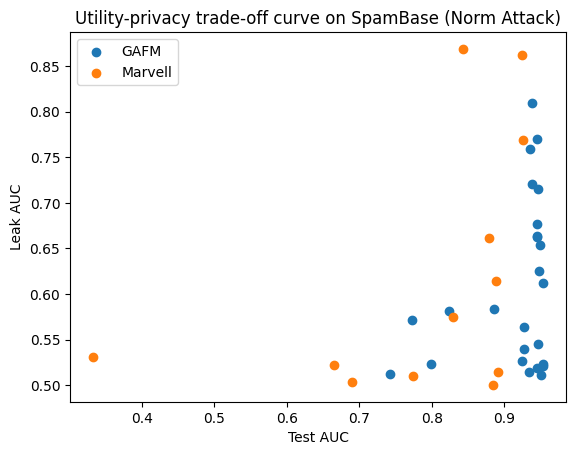

In [56]:
import matplotlib.pyplot as plt

plt.scatter(spam_value, spam_norm, label='GAFM')
plt.scatter(spam_marvell, spam_marvell_norm, label='Marvell')

plt.xlabel('Test AUC')
plt.ylabel('Leak AUC')
plt.title('Utility-privacy trade-off curve on SpamBase (Norm Attack)')
plt.legend()
plt.show()


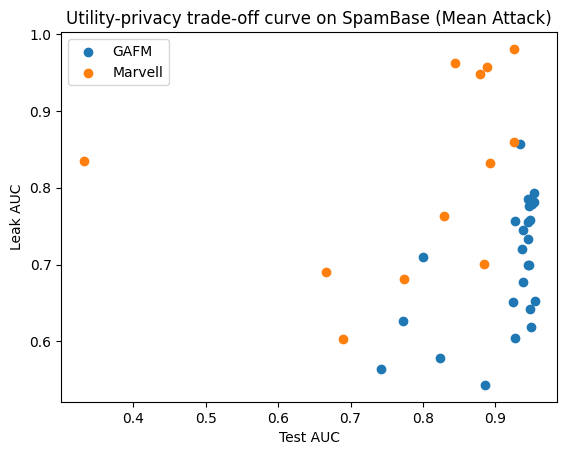

In [57]:
import matplotlib.pyplot as plt
plt.scatter(spam_value, spam_mean, label='GAFM')
plt.scatter(spam_marvell, spam_marvell_mean, label='Marvell')

plt.xlabel('Test AUC')
plt.ylabel('Leak AUC')
plt.title('Utility-privacy trade-off curve on SpamBase (Mean Attack)')
plt.legend()
plt.show()


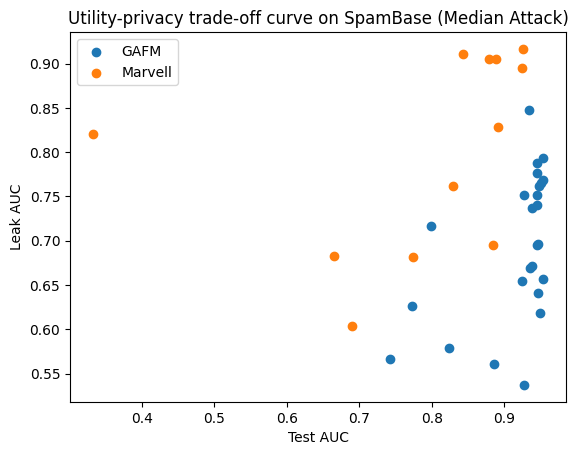

In [58]:
import matplotlib.pyplot as plt
plt.scatter(spam_value, spam_median, label='GAFM')
plt.scatter(spam_marvell, spam_marvell_median, label='Marvell')

plt.xlabel('Test AUC')
plt.ylabel('Leak AUC')
plt.title('Utility-privacy trade-off curve on SpamBase (Median Attack)')
plt.legend()
plt.show()
